In [1]:
import os, sys

from model import pggan, stylegan2
from tqdm import tqdm

import torch
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

print('load model...')
model_path = '/home/hyun_s/Gans/StyleGAN2_featuremap/stylegan/stylegan2_cat256.pth'
G, D= stylegan2(path=model_path, res=256)
G.to(device)
D.to(device)
print('models completes')

load model...
models completes


In [5]:
class dissection():
    def __init__(self, G,D, device=device):
        self.G = G
        self.D = D
        self.G.eval()
        self.D.eval()
        self.device = device
    def g_nonsaturating_loss(self, fake_pred):
        return F.softplus(-fake_pred).mean()
    def tensor_to_numpy(self,x):
        return x.detach().cpu().numpy()

    def feature_map(self, batch=4, z=None):
        '''
        return_type = ['normal','mean','std']
        '''
        if z == None:
            z = torch.randn(batch,512, device=self.device)
        else:
            z = z.to(self.device)
        activations = {}
        grads = {}
        dic = G.mapping(z)
        const = dic['z']
        w = dic['w']
        wp = self.G.truncation(w)
        print(wp.shape)
        grads['z'] = wp
        grads['z'].retain_grad()
        x = self.G.synthesis.early_layer(wp[:, 0])

        for layer_idx in range(self.G.synthesis.num_layers - 1):
            x, style = self.G.synthesis.__getattr__(f'layer{layer_idx}')\
                                            (x, wp[:, layer_idx])
            if layer_idx % 2 == 0:
                temp, style = self.G.synthesis.__getattr__(f'output{layer_idx // 2}')\
                                                     (x, wp[:, layer_idx + 1])
                if layer_idx == 0:
                    image = temp
                else:
                    image = temp + self.G.synthesis.upsample(image)

            name = f'layer{layer_idx}'
            tmp = x
            tmp.retain_grad()
            activations[name] = tmp
            grads[name] = tmp
        out = self.G.synthesis.final_activate(image)# * 127.5 + 127.5
        fake_pred = D(out)
        g_loss = self.g_nonsaturating_loss(fake_pred)
        g_loss.backward()
        # grads['z'] = wp[:,0,:]

        for k in grads.keys():
            grads[k] = grads[k].grad
        self.current_z = z
        return grads, activations, out, z

    def z_gradient(self,batch=4, z=None):
        if z == None:
            g, _, _, z = self.feature_map(batch)
        else:
            g, _, _, z = self.feature_map(batch,z)
        return torch.var(g['z'],axis=1), z

    def act_gradient_var(self, batch=4, z=None):
        if z == None:
            g, _, _, z = self.feature_map(batch)
        else:
            g, _, _, z = self.feature_map(batch,z)
        for k in g.keys():
            g[k] = torch.var(g[k],axis=1)
        return g
        
    def act_var(self, batch=4, z=None):
        if z == None:
            _, a, _, z = self.feature_map(batch)
        else:
            _, a, _, z = self.feature_map(batch,z)
        for k in a.keys():
            a[k] = torch.var(a[k],axis=1)
        return a


    def double_var(self, tensor):
        '''
        tensor (b,c,h,w) dimension
        '''
        var = torch.var(tensor,axis=1)
        out = []
        for x in range(tensor.shape[1]):   
            tmp = torch.cat([tensor[:,:x,...],tensor[:,x+1:,...]],axis=1)
            tmp = torch.var(tmp,axis=1)#
            tmp = var - tmp
            out.append(tmp[:,np.newaxis,...])
        out = torch.cat(out,axis=1)
        return out

In [6]:
diss = dissection(G,D,device=device)
# g, a, o, z = diss.feature_map(batch=8)

In [8]:
s = diss.act_gradient_var(z=z)['layer3'][0]

torch.Size([8, 14, 512])


In [22]:
g['layer1'].shape

torch.Size([8, 512, 8, 8])

In [25]:
cur = diss.double_var(g['layer1'])
for per in cur:
    var = torch.var(per,axis=0)
    drop_pixel = torch.argmax(var.flatten())
    drop_pixel = [drop_pixel//len(var),drop_pixel%len(var)]
    tmp = per[:,drop_pixel[0],drop_pixel[1]]
    tmp[torch.topk(torch.abs(tmp),10).indices] = 0
    per[:,drop_pixel[0],drop_pixel[1]] = tmp

/home/hyun_s/anaconda3/envs/env/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  """


In [39]:
len(per[per==0])>=10

True

/home/hyun_s/anaconda3/envs/env/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 512, 4, 4]) torch.Size([4, 512, 4, 4])
torch.Size([4, 512, 8, 8]) torch.Size([4, 512, 8, 8])
torch.Size([4, 512, 8, 8]) torch.Size([4, 512, 8, 8])


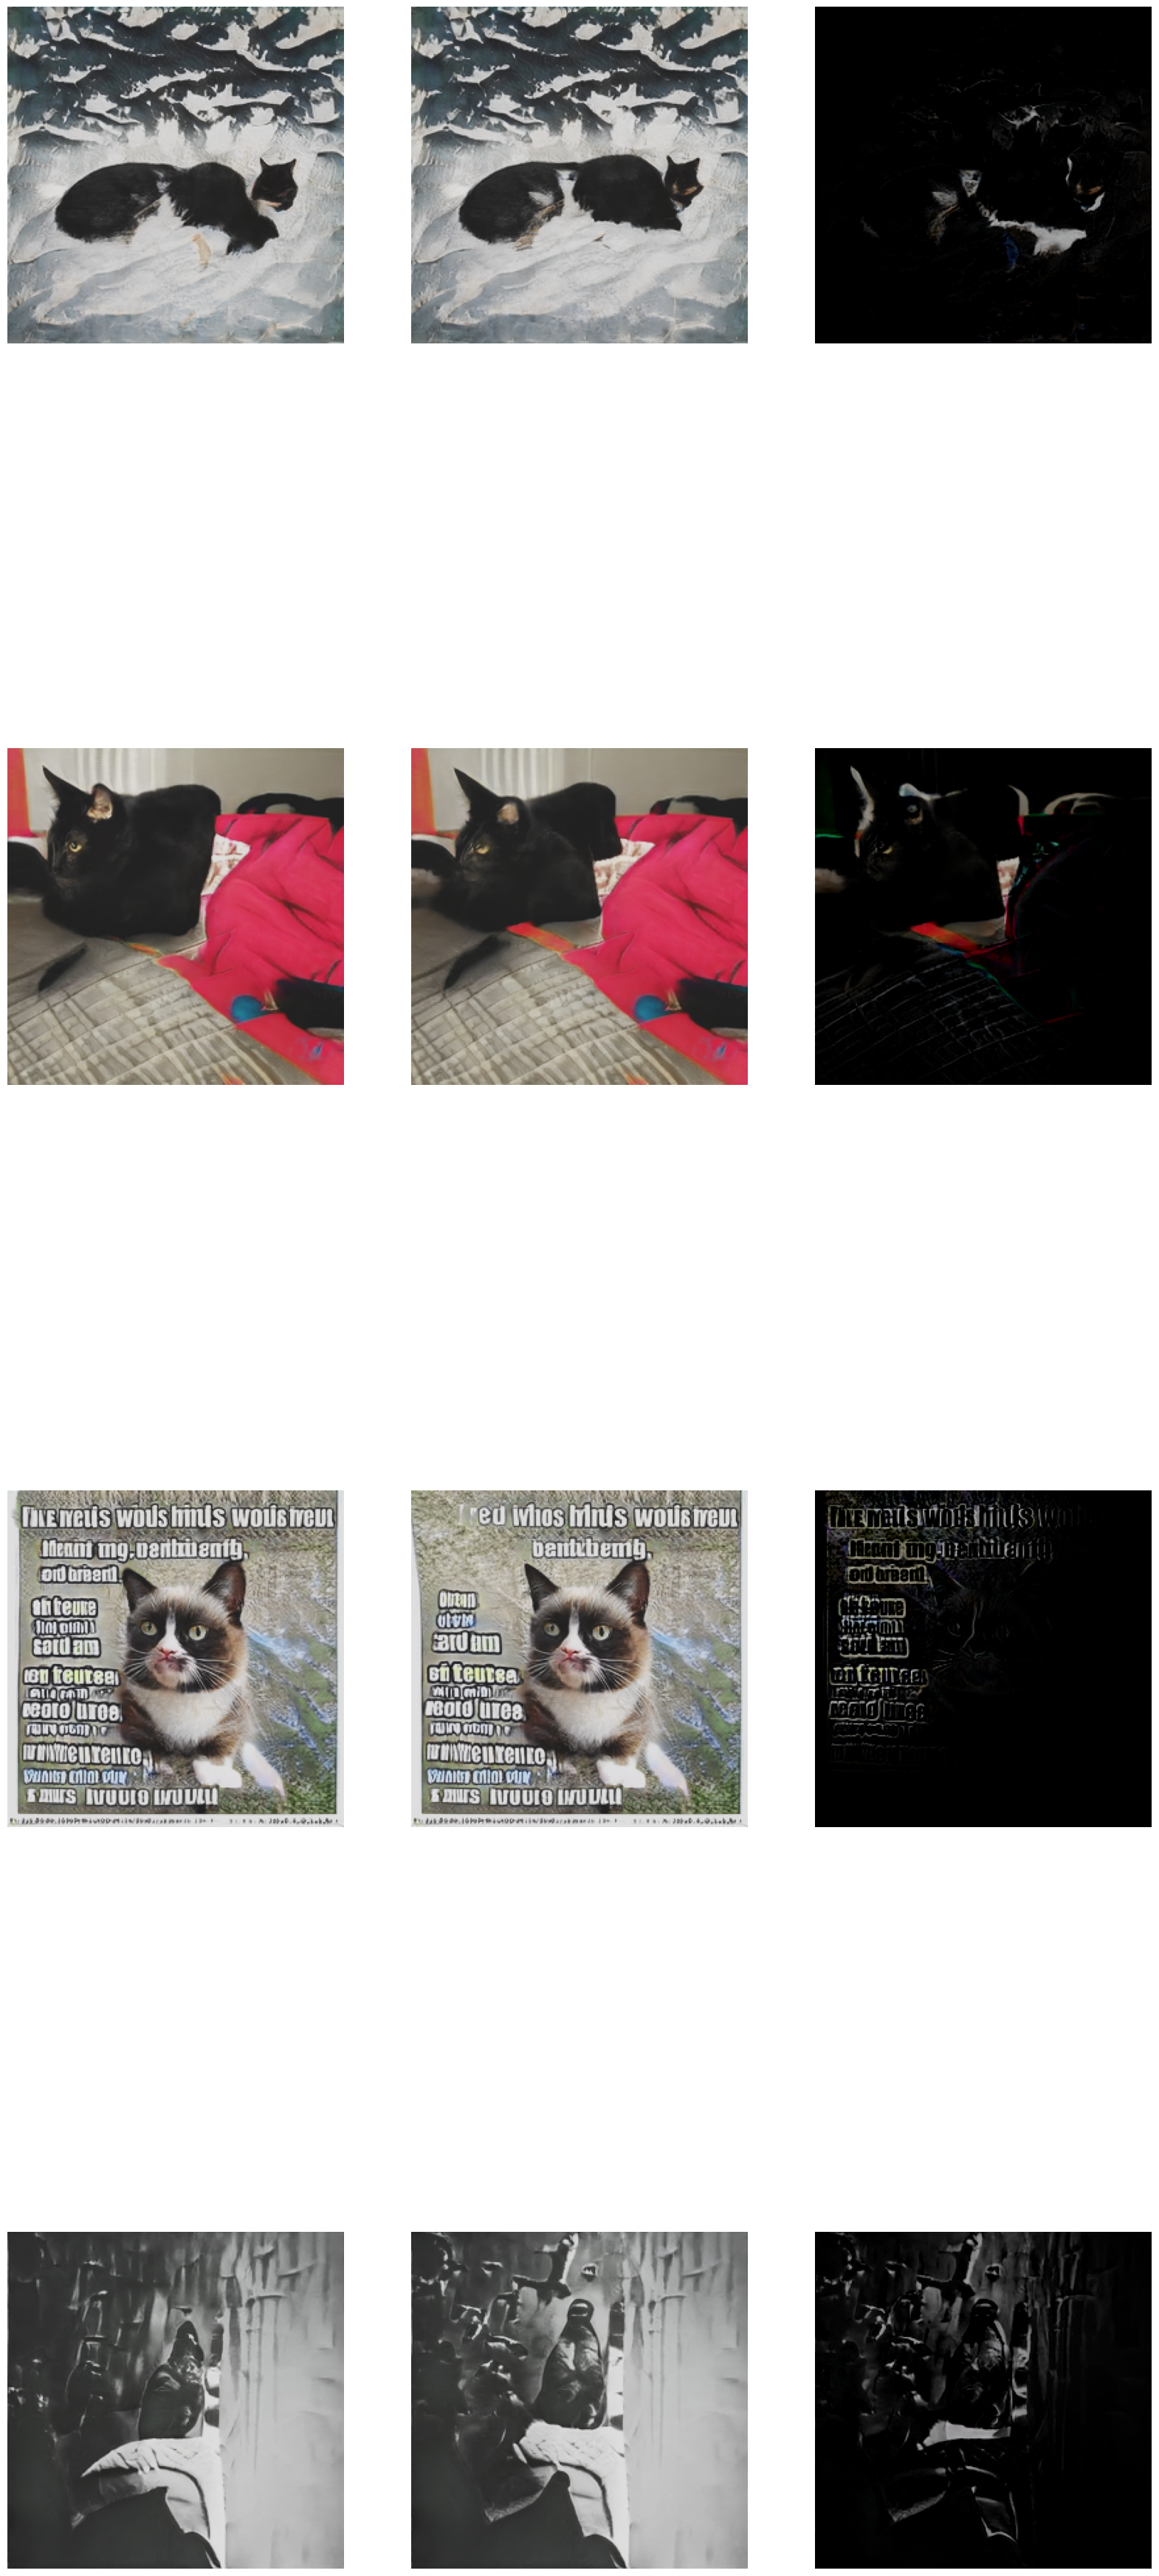

In [94]:
class autocorrection():
    def __init__(self, G,D, device=device):
        self.G = G
        self.D = D
        self.G.eval()
        self.D.eval()
        self.device = device
    def g_nonsaturating_loss(self, fake_pred):
        return F.softplus(-fake_pred).mean()
    def tensor_to_numpy(self,x):
        return x.detach().cpu().numpy()
    def double_var(self, tensor):
        '''
        tensor (b,c,h,w) dimension
        '''
        var = torch.var(tensor,axis=1)
        out = []
        for x in range(tensor.shape[1]):   
            tmp = torch.cat([tensor[:,:x,...],tensor[:,x+1:,...]],axis=1)
            tmp = torch.var(tmp,axis=1)#
            tmp = var - tmp
            out.append(tmp[:,np.newaxis,...])
        out = torch.cat(out,axis=1)
        return out

    def forward(self, batch=4, z=None):
        '''
        return_type = ['normal','mean','std']
        '''
        if z == None:
            z = torch.randn(batch,512, device=self.device)
        else:
            z = z.to(self.device)
        activations = {}
        grads = {}
        dic = G.mapping(z)
        const = dic['z']
        w = dic['w']
        wp = self.G.truncation(w)
        grads['z'] = wp
        grads['z'].retain_grad()
        x = self.G.synthesis.early_layer(wp[:, 0])
        for layer_idx in range(self.G.synthesis.num_layers - 1):
            x, style = self.G.synthesis.__getattr__(f'layer{layer_idx}')\
                                            (x, wp[:, layer_idx])
            if layer_idx % 2 == 0:
                temp, style = self.G.synthesis.__getattr__(f'output{layer_idx // 2}')\
                                                     (x, wp[:, layer_idx + 1])
                if layer_idx == 0:
                    image = temp
                else:
                    image = temp + self.G.synthesis.upsample(image)

            name = f'layer{layer_idx}'
            tmp = x
            tmp.retain_grad()
            activations[name] = tmp
            grads[name] = tmp
        out = self.G.synthesis.final_activate(image)
        fake_pred = D(out)
        g_loss = self.g_nonsaturating_loss(fake_pred)
        g_loss.backward()

        for k in grads.keys():
            grads[k] = grads[k].grad
        self.current_z = z
        return grads, activations, out, z

    def correction(self,layers=['layer1','layer2','layer0'],
                    percent=0.1):
        g, a, o, z = self.forward(batch=4)
        # find drop index (current all channel)
        drop_idx = {}
        for layer in layers:
            per_img = []
            cur = self.double_var(g[layer])
            n = int(g[layer].shape[1] * percent)
            for per in cur:
                outs = torch.ones_like(per)
                var = torch.var(per,axis=0)
                drop_pixel = torch.argmax(var.flatten())
                drop_pixel = [drop_pixel//len(var),drop_pixel%len(var)]
                tmp = per[:,drop_pixel[0],drop_pixel[1]]
                tmp[torch.topk(torch.abs(tmp),n).indices] = 0
                per = torch.ones_like(per)
                per[:,drop_pixel[0],drop_pixel[1]] = tmp
                per_img.append(per[np.newaxis,...])
            # print(n)
            # print(torch.cat(per_img).shape)
            drop_idx[layer] = torch.cat(per_img,axis=0)
        dic = G.mapping(z)
        const = dic['z']
        w = dic['w']
        wp = self.G.truncation(w)
        # wp = z
        x = self.G.synthesis.early_layer(wp[:, 0])

        for layer_idx in range(self.G.synthesis.num_layers - 1):
            # print('forward ' + f'layer{layer_idx}')
            # print(x.shape)
            x, style = self.G.synthesis.__getattr__(f'layer{layer_idx}')\
                                            (x, wp[:, layer_idx])
            if layer_idx % 2 == 0:
                temp, style = self.G.synthesis.__getattr__(f'output{layer_idx // 2}')\
                                                     (x, wp[:, layer_idx + 1])
                if layer_idx == 0:
                    image = temp
                else:
                    image = temp + self.G.synthesis.upsample(image)
            name = f'layer{layer_idx}'
            if name in layers:
                print(x.shape,drop_idx[name].shape)
                x = torch.multiply(x ,drop_idx[name].to(device))

        out = self.G.synthesis.final_activate(image)
        return o, out
auto = autocorrection(G,D,device=device)


img = auto.correction(percent=0.8)
r=4
c=3
idx=1

plt.figure(figsize=(20,50))

for before,after in zip(img[0],img[1]):
    x = before.permute(1,2,0)
    x = x.detach().cpu().numpy()
    x = (x+1)*127.5
    x = x.astype(int)
    b = x
    plt.subplot(r,c,idx)
    plt.axis('off')
    plt.imshow(b)
    idx+=1
    x = after.permute(1,2,0)
    x = x.detach().cpu().numpy()
    x = (x+1)*127.5
    x = x.astype(int)
    a = x
    plt.subplot(r,c,idx)
    plt.axis('off')
    plt.imshow(a)
    idx+=1
    
    plt.subplot(r,c,idx)
    plt.axis('off')
    plt.imshow((a-b))
    idx+=1

/home/hyun_s/anaconda3/envs/env/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


0
torch.Size([4, 512, 16, 16])
0
torch.Size([4, 512, 8, 8])
0
torch.Size([4, 512, 16, 16])
{'layer4': tensor([[[[-1.9902e-12, -5.2300e-12, -1.2687e-11,  ..., -1.7681e-11,
           -9.6034e-12, -6.1280e-12],
          [ 3.0254e-12, -1.3545e-12, -1.0862e-11,  ..., -2.0421e-10,
           -3.7778e-11, -1.5251e-11],
          [-3.8541e-13, -1.0218e-12, -2.5897e-12,  ..., -2.7732e-10,
           -9.4936e-11, -3.0312e-11],
          ...,
          [-1.1239e-10, -5.4136e-11, -2.7889e-11,  ..., -4.2633e-12,
           -7.4580e-12,  3.9910e-12],
          [-3.5328e-10, -3.9700e-11, -8.0900e-12,  ..., -2.0707e-10,
           -6.3640e-11, -1.0105e-11],
          [-3.3122e-11, -9.8144e-12, -2.1168e-12,  ..., -1.2795e-10,
           -1.1845e-10,  7.2720e-13]],

         [[-1.3678e-12,  8.3134e-13,  1.2399e-12,  ..., -1.9174e-11,
           -1.0210e-11, -9.7993e-12],
          [-4.1560e-12, -6.2990e-12, -4.3308e-12,  ..., -2.2149e-10,
           -3.8009e-11, -3.6691e-12],
          [-4.9147e-13, -

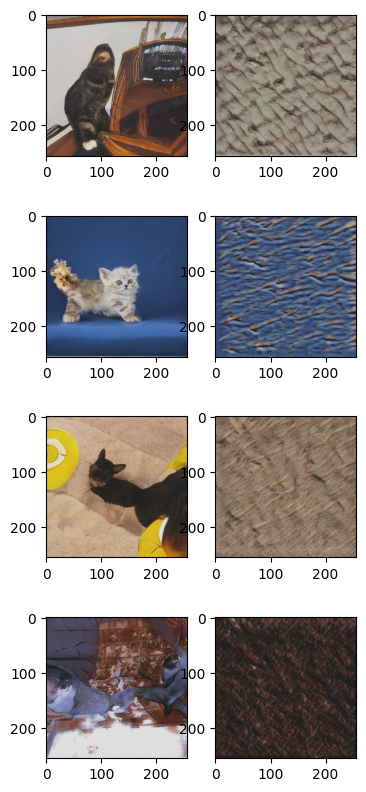

In [1]:
l1 = diss.double_var(grads['layer4'])

NameError: name 'diss' is not defined

In [8]:

import cv2
grads, activations, out, z = diss.feature_map()
# l1 = diss.double_var(grads['layer4'])
imgs = out.permute(0,2,3,1).detach().cpu().numpy()
imgs = (imgs + 1)* 127.5
imgs = imgs.astype(int)

torch.Size([4, 14, 512])


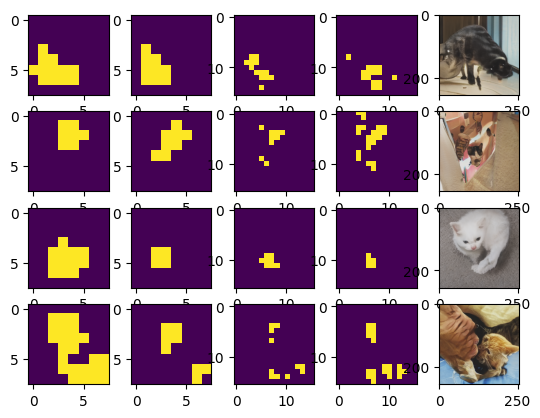

In [52]:
per_layer = []

rows = 4
cols = 5
start = 0
for idx in range(len(imgs)):
    for x in range(1+start,5+start):
        l = diss.double_var(grads['layer{}'.format(x)])
        l = l.detach().cpu().numpy()
        l = np.sum(np.abs(l),axis=1)[idx]
        l = (l - l.min())/(l.max()-l.min())*255
        l = l.astype('uint8')
        th, l = cv2.threshold(l, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        per_layer.append(l)
        # break
        # l = cv
        plt.subplot(rows,cols,idx*cols+x-start)
        plt.imshow(l)
    plt.subplot(rows,cols,idx*cols + 5)
    plt.imshow(imgs[idx])


In [ ]:
type(x)

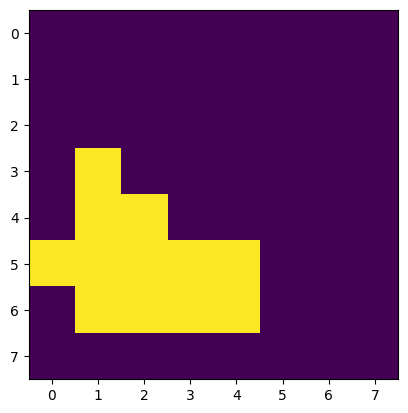

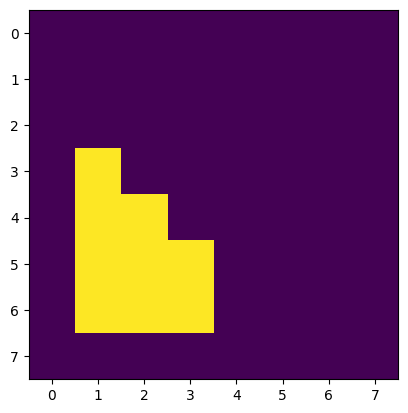

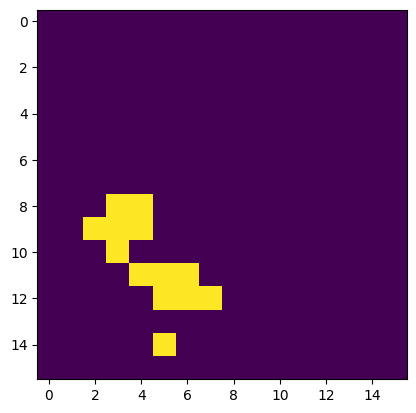

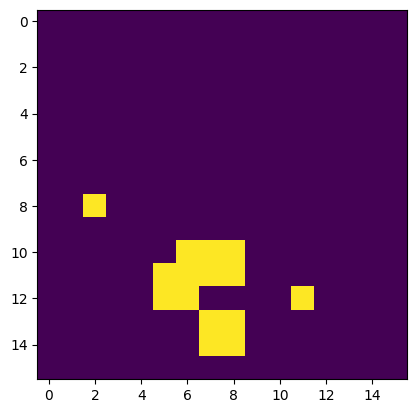

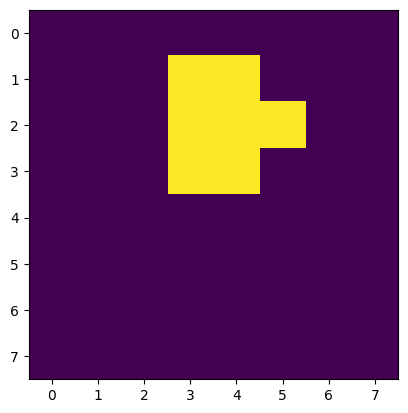

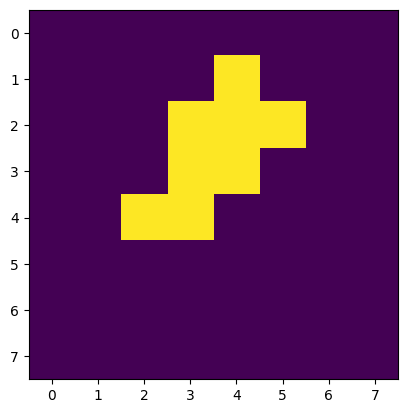

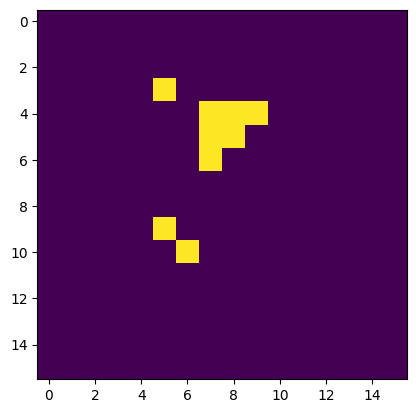

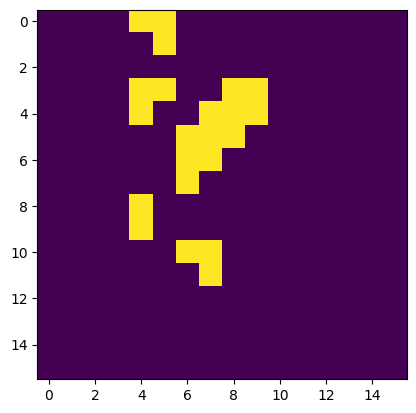

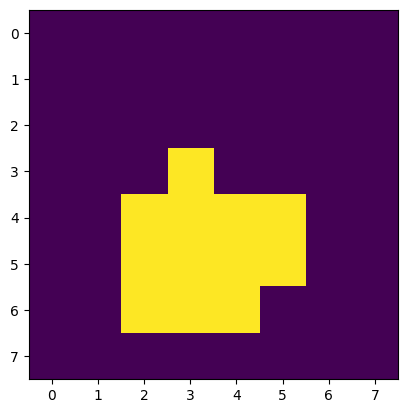

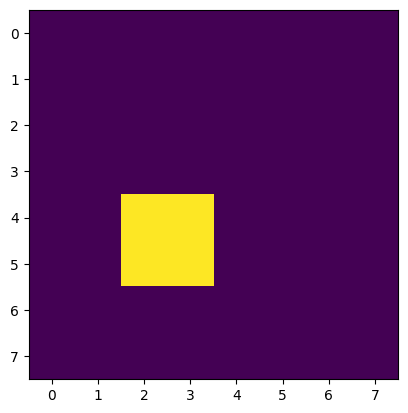

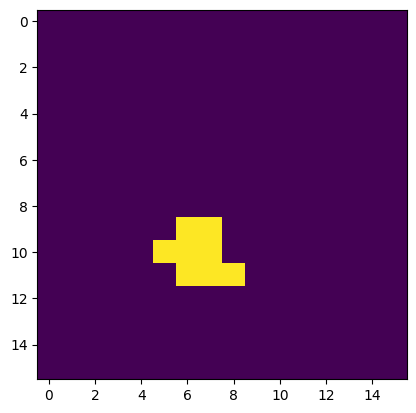

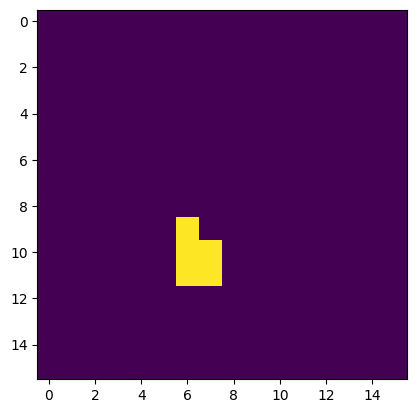

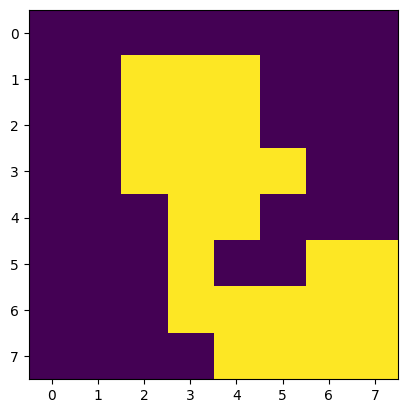

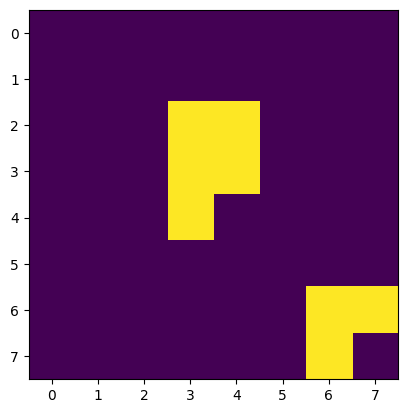

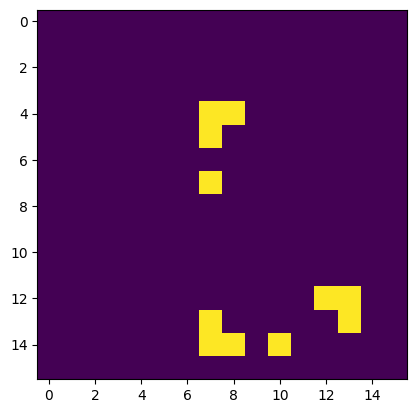

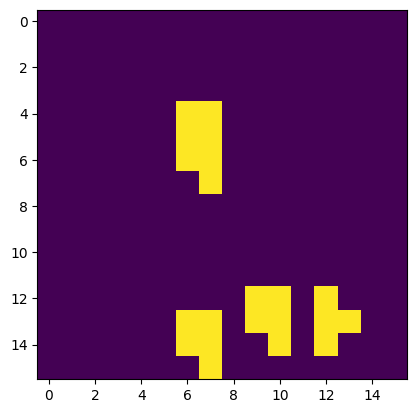

In [50]:
for x in per_layer:
    # x = (x - np.mean(x) / np.std(x))
    # if len(x)<=8:
    #     continue
    x = (x - x.min())/(x.max()-x.min())*255
    x = x.astype('uint8')
    th, x = cv2.threshold(x, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    plt.imshow(x)
    # sns.histplot(data=x.flatten())
    plt.show()

In [105]:
l.max()

4.1000888e-08